Importing Necessary Libraries and Modules

In [1]:
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2fb8043368a0765f43d3cb9516fb691566b06ba8e1a57e38fa7e7ddcdf5395b6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
# Basic libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# For handling class imbalance
from imblearn.over_sampling import SMOTE

from google.colab import drive


# For XAI (Explainable AI)
import shap
from lime.lime_tabular import LimeTabularExplainer

Loading and Previewing the Dataset

In [4]:
# Load the dataset
# Mount Google Drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/creditcard_2023.csv"   # Replace with the actual path to your dataset
df = pd.read_csv(file_path)


# Show the first few rows to understand the structure of the dataset
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


Check for Missing Values

In [5]:
# Check for missing data in the dataset
missing_data = df.isnull().sum()
missing_data_percentage = (missing_data / len(df)) * 100
print(f"Missing data percentage per column:\n{missing_data_percentage}")

Missing data percentage per column:
id        0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64


Data Types and Data Overview

In [6]:
# Get a summary of the data types and basic stats
print(df.info())
print("\nDescriptive statistics of the dataset:\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

Class Distribution

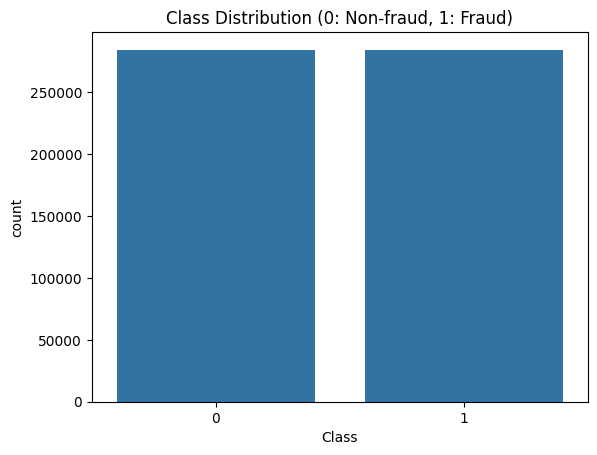

In [7]:
# Visualizing the class distribution
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Non-fraud, 1: Fraud)')
plt.show()

Correlation Matrix Heatmap

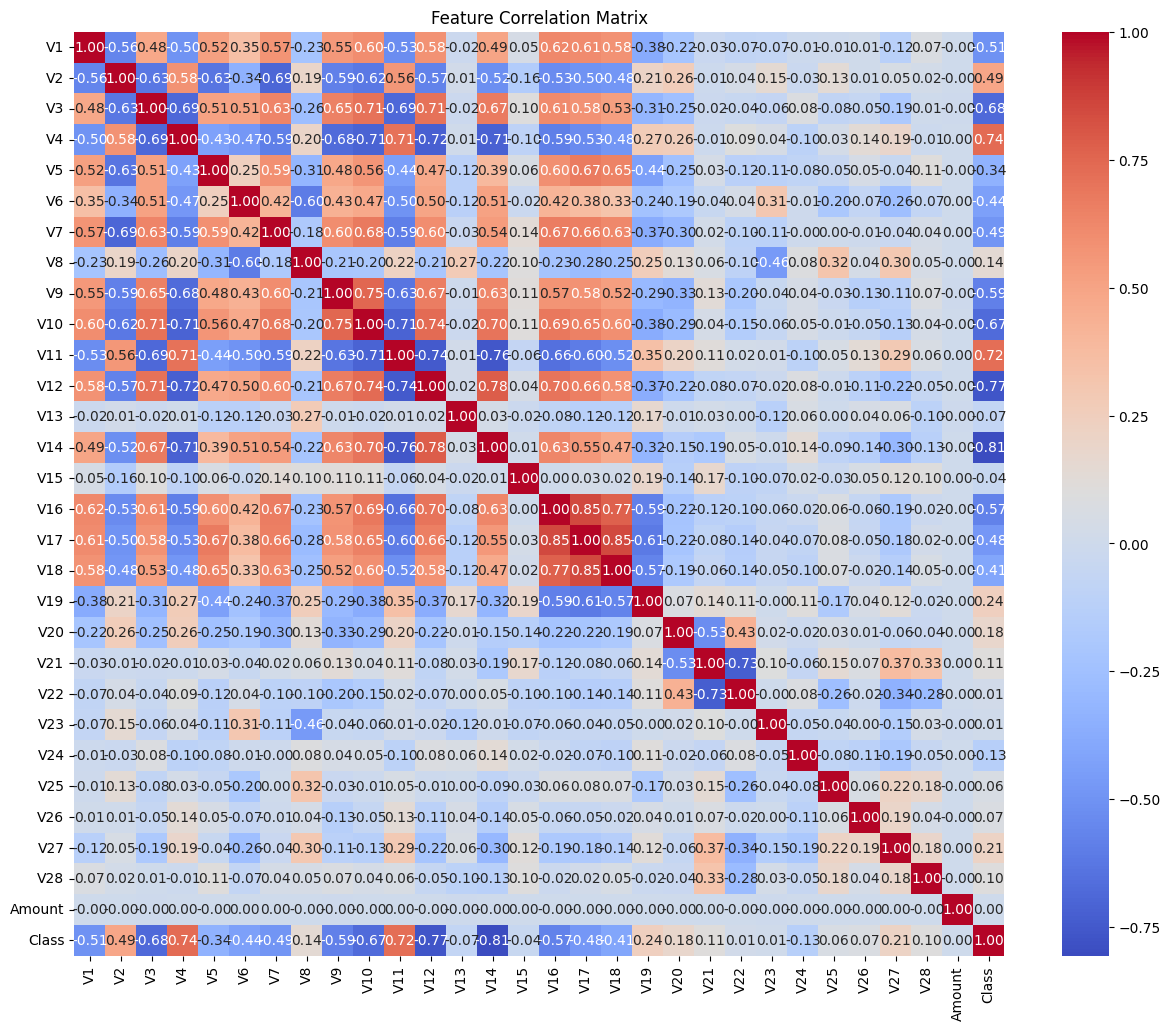

In [8]:
# Plotting the correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(df.drop(columns=['id']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

Histograms of All Features

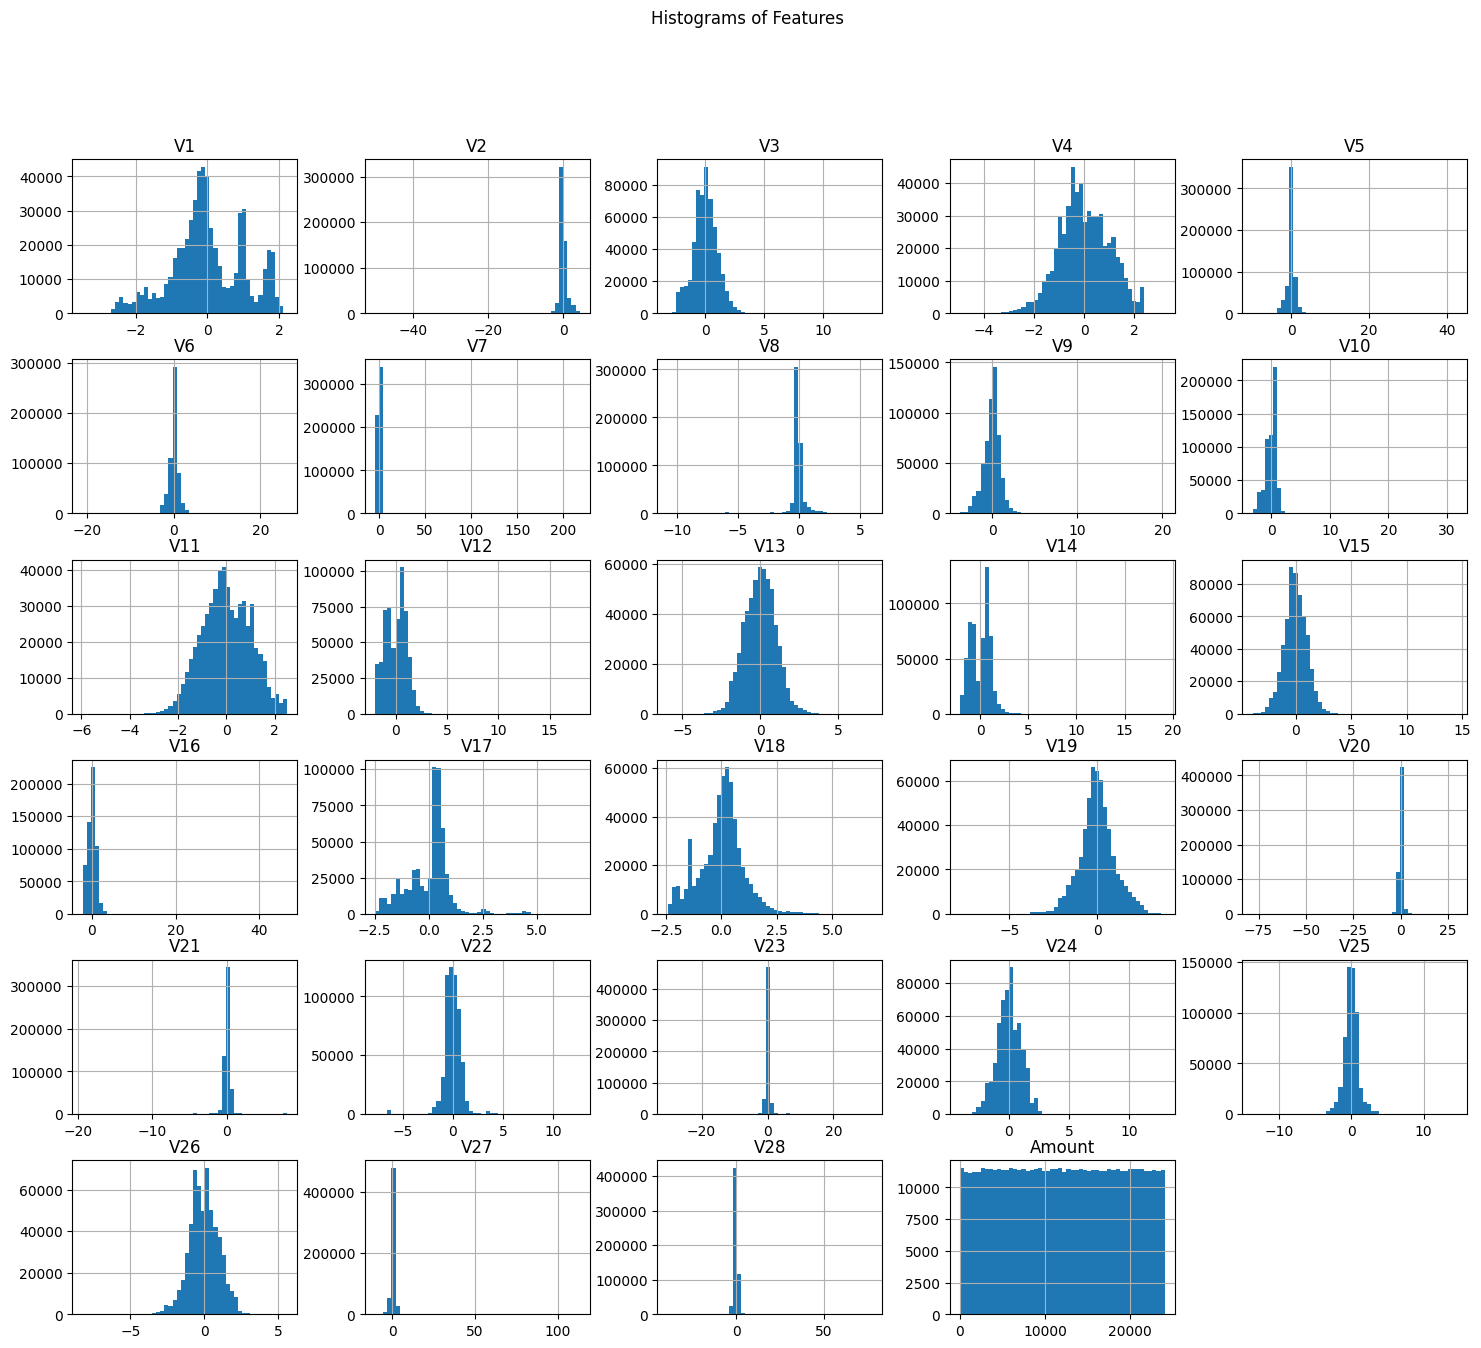

In [10]:
# Plotting histograms for each feature
df.drop(columns=['Class', 'id']).hist(figsize=(18, 15), bins=50)
plt.suptitle('Histograms of Features')
plt.show()

Z-Score Calculation and Outlier Detection

In [11]:
from scipy.stats import zscore

# Compute the z-scores for the features (excluding 'id' and 'Class')
z_scores = np.abs(zscore(df.drop(columns=['Class', 'id'])))

# Define a threshold for identifying outliers
outliers = (z_scores > 3).all(axis=1)

# Display outliers
outliers_df = df[outliers]
print(f"Number of outliers: {len(outliers_df)}")

Number of outliers: 0


Handling Class Imbalance Using SMOTE

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


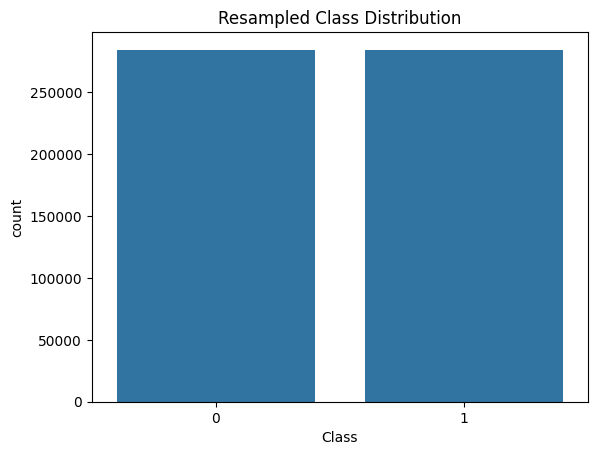

In [12]:
# Separate features (X) and target (y)
X = df.drop(columns=['Class', 'id'])
y = df['Class']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
sns.countplot(x=y_resampled)
plt.title('Resampled Class Distribution')
plt.show()

Feature Scaling (Standardization)

In [13]:
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Show the scaled feature range for the first few rows
print("Scaled Features (First 5 rows):")
print(X_scaled[:5])

Scaled Features (First 5 rows):
[[-0.2606478  -0.46964845  2.49626608 -0.08372391  0.12968124  0.73289825
   0.51901362 -0.13000605  0.72715927  0.63773454 -0.98702001  0.2934381
  -0.94138613  0.54901989  1.80487858  0.21559799  0.51230666  0.33364372
   0.12427016  0.0912019  -0.11055168  0.21760614 -0.13479449  0.16595912
   0.12627998 -0.43482398 -0.08123011 -0.15104549  0.85844694]
 [ 0.98509973 -0.35604509  0.55805635 -0.4296539   0.27714026  0.42860452
   0.40646604 -0.13311827  0.3474519   0.52980798  0.14010733  1.56424577
   0.57407401  0.62771874  0.70612133  0.78918836  0.40380988  0.20179937
  -0.3406871  -0.23398416 -0.19493596 -0.60576091  0.07946908 -0.57739487
   0.19008971  0.2965027  -0.24805206 -0.06451192 -0.79636931]
 [-0.26027161 -0.94938461  1.72853778 -0.45798629  0.07406165  1.41948114
   0.74351107 -0.09557601 -0.26129662  0.6907078  -0.27298493  0.65920066
   0.80517319  0.61687439  3.06902477 -0.57751352  0.88652597  0.23944166
  -2.36607893  0.36165231 -0.

Splitting the Data into Training and Test Sets

In [14]:
# Split data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 454904
Test set size: 113726


Decision Tree Classifier Model

In [15]:
# Train a Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Classifier Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



Random Forest Classifier Model

In [16]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classifier Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



Neural Network Classifier Model

In [17]:
# Train a Neural Network Classifier (MLP)
nn_model = MLPClassifier(random_state=42, max_iter=500)
nn_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_nn = nn_model.predict(X_test)
print("Neural Network Classifier Classification Report:")
print(classification_report(y_test, y_pred_nn))

Neural Network Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



KMeans Unsupervised Clustering for Anomaly Detection

In [18]:
# KMeans clustering to detect outliers/anomalies
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

# Predict clusters and evaluate
y_pred_kmeans = kmeans.predict(X_test)
print("KMeans Classifier Classification Report:")
print(classification_report(y_test, y_pred_kmeans))

KMeans Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     56750
           1       1.00      0.76      0.87     56976

    accuracy                           0.88    113726
   macro avg       0.90      0.88      0.88    113726
weighted avg       0.90      0.88      0.88    113726



Isolation Forest Unsupervised Model for Anomaly Detection

In [19]:
# Isolation Forest for anomaly detection
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_train)

# Predict anomalies
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # Convert -1 to fraud, 1 to non-fraud
print("Isolation Forest Classifier Classification Report:")
print(classification_report(y_test, y_pred_iso))

Isolation Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.99      0.70     56750
           1       0.92      0.17      0.29     56976

    accuracy                           0.58    113726
   macro avg       0.73      0.58      0.49    113726
weighted avg       0.73      0.58      0.49    113726



Evaluating Models with Confusion Matrix

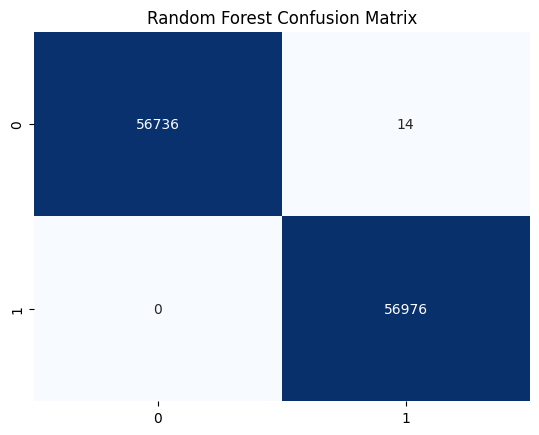

In [20]:
# Confusion Matrix for Random Forest Classifier
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.show()

Precision-Recall Curve for Random Forest

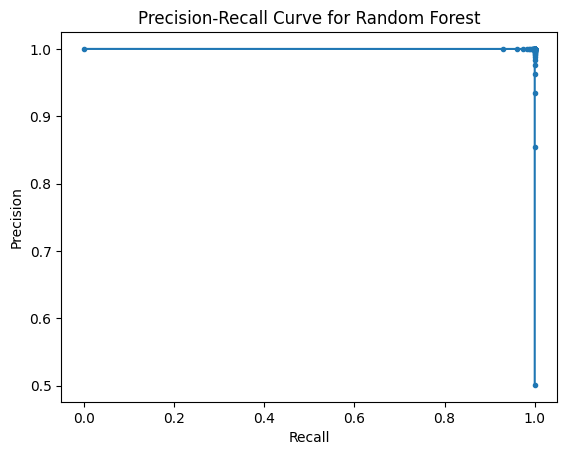

In [21]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve for Random Forest
precision, recall, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve for Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

F1-Score Evaluation for Different Models

In [22]:
from sklearn.metrics import f1_score

# F1-Score for Random Forest
f1_rf = f1_score(y_test, y_pred_rf)
print(f"F1-Score for Random Forest: {f1_rf:.2f}")

# F1-Score for Decision Tree
f1_dt = f1_score(y_test, y_pred_dt)
print(f"F1-Score for Decision Tree: {f1_dt:.2f}")

# F1-Score for Neural Network
f1_nn = f1_score(y_test, y_pred_nn)
print(f"F1-Score for Neural Network: {f1_nn:.2f}")

F1-Score for Random Forest: 1.00
F1-Score for Decision Tree: 1.00
F1-Score for Neural Network: 1.00


In [23]:
!pip install shap
!pip install lime

# Explainable AI (XAI)

Partial Dependence Plots (PDPs)

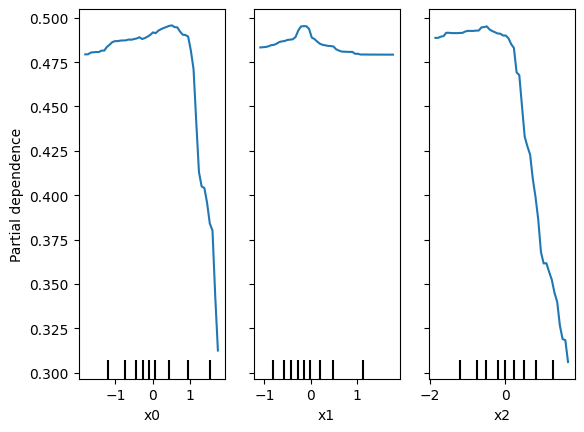

In [25]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Plot PDP for specific features
features = [0, 1, 2]  # specify the features you want to analyze
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=features, grid_resolution=50)

plt.show()

In [26]:
from sklearn.inspection import permutation_importance
# Define feature names (as X_train is a NumPy array)
# Adjust the number of features according to your dataset
num_features = X_train.shape[1]  # Number of features in the dataset
feature_names = [f'Feature{i+1}' for i in range(num_features)]  # Create placeholder names

# Compute permutation feature importance
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame with feature names and importance scores
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
importance_df.head(10)

,Feature,Importance
11,Feature12,0.100807
3,Feature4,0.079099
13,Feature14,0.063082
10,Feature11,0.035947
9,Feature10,0.015915
7,Feature8,0.010672
2,Feature3,0.006723
16,Feature17,0.002120
4,Feature5,0.001789
1,Feature2,0.001587


Permutation Feature Importance

Feature Importance from Tree-based Models

In [27]:
# Get feature importances from the Random Forest model
rf_importance = rf_model.feature_importances_

# Create a DataFrame with feature names and importance scores
importance_rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importance
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
importance_rf_df.head(10)

,Feature,Importance
9,Feature10,0.166442
3,Feature4,0.146999
13,Feature14,0.137746
11,Feature12,0.104736
10,Feature11,0.088431
16,Feature17,0.058372
15,Feature16,0.053973
6,Feature7,0.044039
2,Feature3,0.037529
1,Feature2,0.021536


Global Surrogate Models

Surrogate Model Accuracy: 1.0000


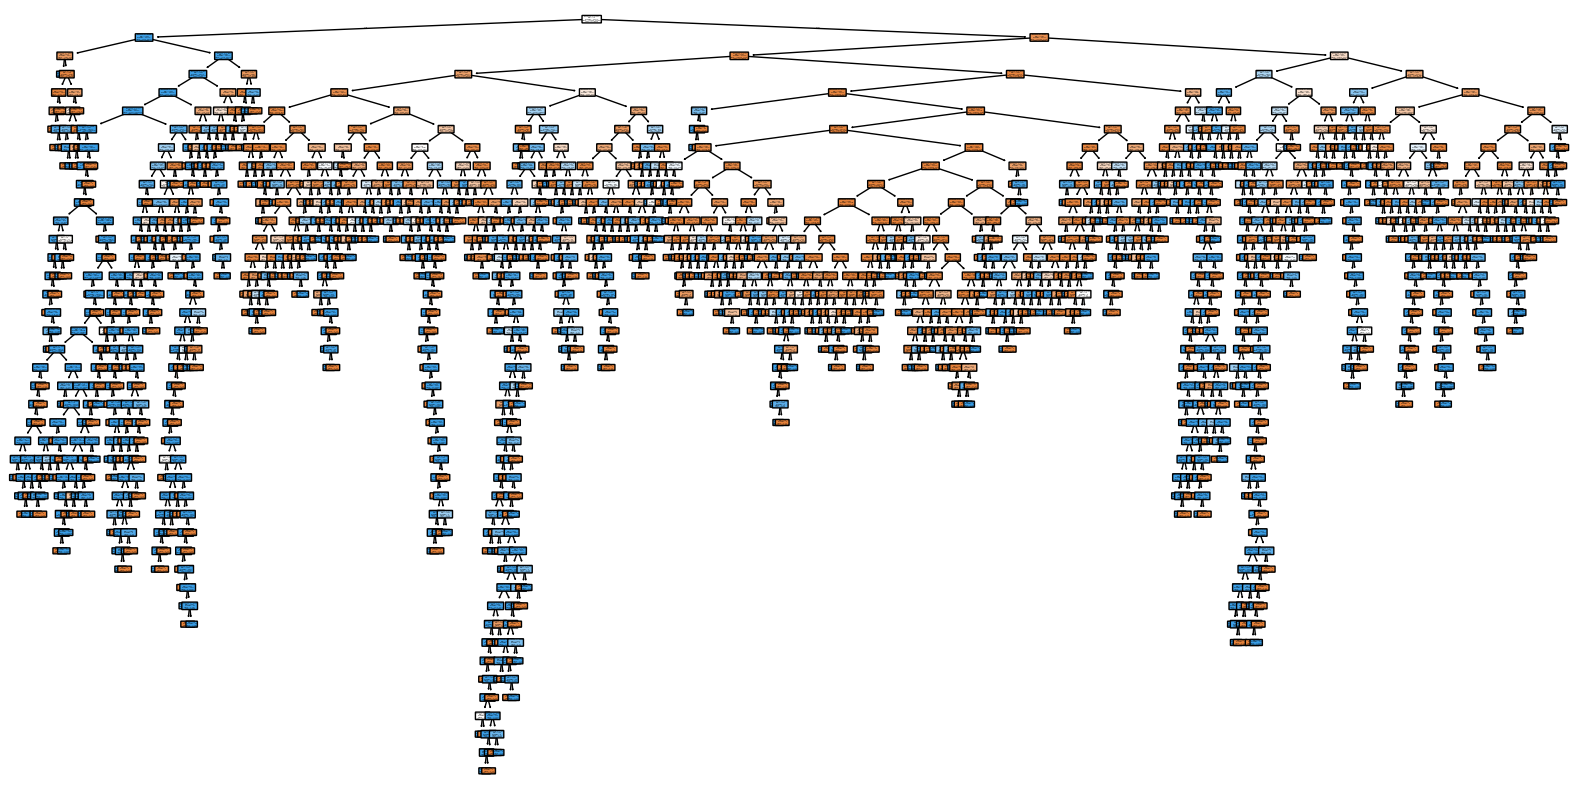

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Get predictions from the Random Forest model
y_pred_rf = rf_model.predict(X_train)

# Train a Decision Tree as a surrogate model on the predictions of the RF model
surrogate_model = DecisionTreeClassifier(random_state=42)
surrogate_model.fit(X_train, y_pred_rf)

# Evaluate the surrogate model
y_pred_surrogate = surrogate_model.predict(X_train)
surrogate_accuracy = accuracy_score(y_pred_rf, y_pred_surrogate)
print(f"Surrogate Model Accuracy: {surrogate_accuracy:.4f}")

# Visualize the surrogate decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(surrogate_model, filled=True, feature_names=feature_names, class_names=['Non-Fraud', 'Fraud'], rounded=True)
plt.show()

Making it more clear

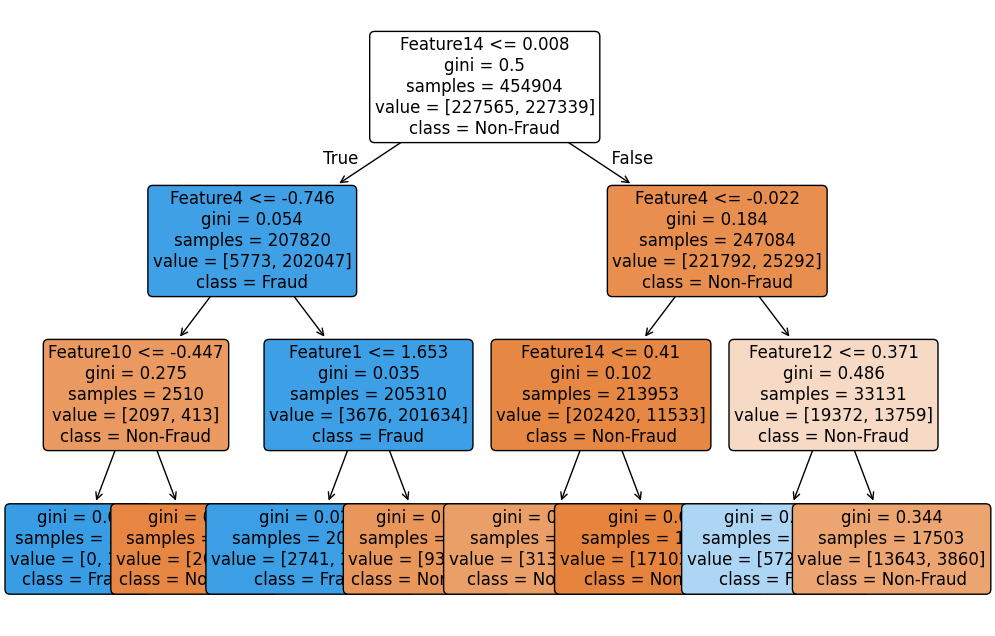

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Limiting the depth of the global surrogate model to prevent overfitting and improve clarity
max_depth = 3  # Adjust as needed for clarity
global_surrogate = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
# Fit the global surrogate model on the training data
global_surrogate.fit(X_train, y_train)

# Visualize the global surrogate tree
plt.figure(figsize=(12, 8))
plot_tree(
    global_surrogate,
    filled=True,
    feature_names=feature_names,
    class_names=['Non-Fraud', 'Fraud'],
    rounded=True,
    fontsize=12
)
plt.show()

Shallow Decision Trees for Local Interpretability

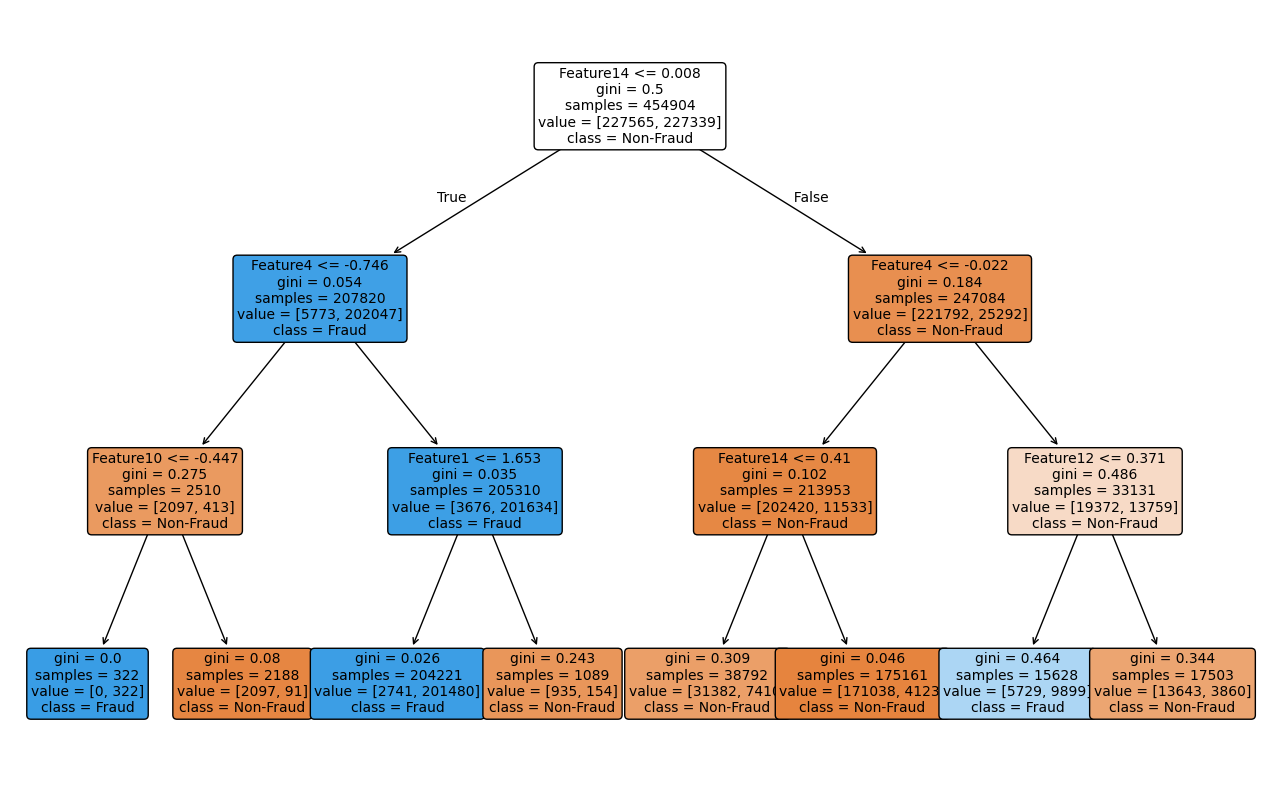

Prediction for the instance: [1]


In [30]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Let's take a single instance from the test set for local interpretation
single_instance = X_test[0].reshape(1, -1)  # Get the first instance from the test set (for numpy array)

# Train a shallow decision tree to explain this instance's prediction
shallow_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
shallow_tree.fit(X_train, y_train)

# Visualize the shallow decision tree with adjusted size and font settings for clarity
plt.figure(figsize=(16, 10))
plot_tree(
    shallow_tree,
    filled=True,
    feature_names=feature_names,
    class_names=['Non-Fraud', 'Fraud'],
    rounded=True,
    fontsize=10
)
plt.show()

# Predict the outcome for the selected instance
prediction = shallow_tree.predict(single_instance)
print(f"Prediction for the instance: {prediction}")

Feature Importance Visualization for Random Forest

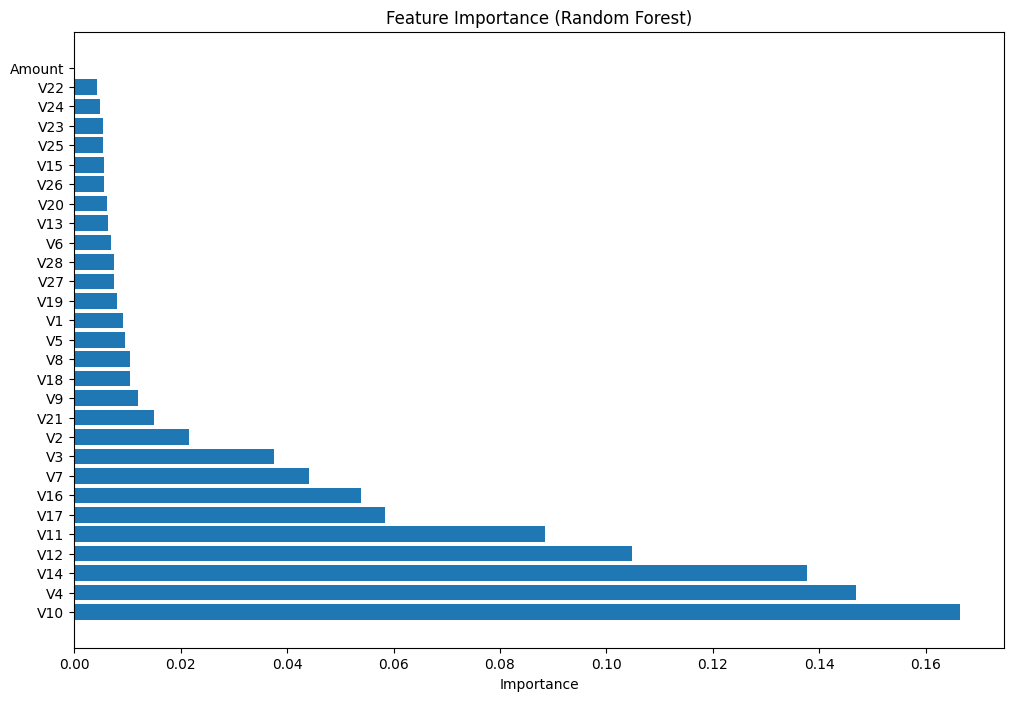

In [31]:
# Feature importance from Random Forest
feature_importance = rf_model.feature_importances_

# Sort and plot the feature importance
indices = np.argsort(feature_importance)[::-1]
plt.figure(figsize=(12, 8))
plt.title('Feature Importance (Random Forest)')
plt.barh(range(X_train.shape[1]), feature_importance[indices])
plt.yticks(range(X_train.shape[1]), X.columns[indices])
plt.xlabel('Importance')
plt.show()

Model Saving

In [32]:
import joblib

# Save the trained Random Forest model for future use
joblib.dump(rf_model, 'fraud_detection_rf_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Model Loading and Inference

In [33]:
# Load the saved model and scaler for inference
loaded_rf_model = joblib.load('fraud_detection_rf_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')

# Transform the new data using the loaded scaler
new_data = np.array([X_test[0]])  # Example data for prediction
new_data_scaled = loaded_scaler.transform(new_data)

# Predict the class
prediction = loaded_rf_model.predict(new_data_scaled)
print(f"Prediction for the new data: {prediction}")

Prediction for the new data: [1]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
